In [1]:
%%time
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import pandas as pd
import numpy as np
import scipy.io.wavfile
from scipy import fftpack

import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

from os import sep
from os.path import isfile, join, abspath, expanduser
import platform

from moviepy.editor import AudioFileClip, VideoFileClip

from sklearn.decomposition import PCA
from sklearn.externals import joblib
from ggplot import *

Wall time: 51.6 s


In [2]:
home = expanduser("~")
dirpath = join(home,"Downloads","videos")
file_basename = 'trainingData'
eventFileName = join(dirpath, file_basename+'.csv')
event_data = pd.read_csv(eventFileName, sep=',',header=0)
print(len(event_data),' events loaded')


219  events loaded


In [3]:
# Compute offset of each clip in the new clips collection and add to DataFrame
offset=np.cumsum(event_data["timeToCapture"])
event_data["offset"]=offset-event_data["timeToCapture"]
# Prepare a list of labels
labels=[row["eventName"] 
        for index,row in event_data.iterrows() 
        for i in np.arange(row["offset"],row["offset"]+row["timeToCapture"])]

# Build a sound array from training data and perform FFT

In [4]:
%%time
F = []
samprate = 44100
for index, row in event_data.iterrows():
    #print row['secondOffset'], row['timeToCapture']
    videoFileName = join(dirpath, row['fileName'])
    if isfile(videoFileName):
        audioClip = AudioFileClip(videoFileName).subclip(row['secondOffset'],row['secondOffset']+row['timeToCapture'])
        wavClip = audioClip.to_soundarray(fps=samprate)
        wavdata = wavClip.reshape(-1, samprate,  2)
        dims = wavdata.shape
        for sec in np.arange(dims[0]):
            ch1 = scipy.fftpack.fft(wavdata[sec,:,0])[:samprate//2] # Left channel
            ch2 = scipy.fftpack.fft(wavdata[sec,:,1])[:samprate//2] # Right channel
            ch = np.vstack([ch1,ch2])
            F.append(ch)
        del audioClip
    else:
        print('Could not find file ', videoFileName)

F = np.absolute(F)/samprate
F_db = 20*np.log10(2*F)  # Dimensions are (seconds, channels, samples)
f = scipy.fftpack.fftfreq(samprate, 1.0/samprate)[:samprate//2]

Wall time: 1min 58s


# Play a video clip

In [28]:
def getClip(path,offset,length):
    videoClip = VideoFileClip(path).subclip(offset,offset+length)
    print('Playing {0}, offset={1}, length={2}'.format(path,offset,length))
    return videoClip

def getEvent(eventNumber):
    offset=int(event_data.iloc[eventNumber-1]["secondOffset"])
    length=int(event_data.iloc[eventNumber-1]["timeToCapture"])
    path=join(dirpath, event_data.iloc[eventNumber-1]["fileName"])
    videoClip = VideoFileClip(path).subclip(offset,offset+length)
    print('Playing {0}, offset={1}, length={2}'.format(path,offset,length))
    return videoClip

Play an event number from event file (first event is #1 which is in line #2 in the file)

In [29]:
clip = getEvent(104)  
clip.ipython_display(width=480, autoplay=True) 

Playing C:\Users\Roy\Downloads\videos\bay_lei_1st_half_eng.mp4, offset=2367, length=7


 99%|██████████████████████████████████████████████████████████████████████████████▌| 175/176 [00:01<00:00, 169.52it/s]


Play a portion of a clip using offset and length in seconds 

# Plot frequency vs. amplitude

In [86]:
def plotFrequencySpectrum(second):
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 3, 3)
    plt.plot(f,np.transpose(F_db[second-1,:,:]), alpha=0.5)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude(in dB)')
    plt.subplot(1, 3, 2)
    plt.plot(f,np.transpose(F[second-1,:,:]), alpha=0.4)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.subplot(1, 3, 1)
    plt.plot(wavdata[second-1,:,], alpha=0.4)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

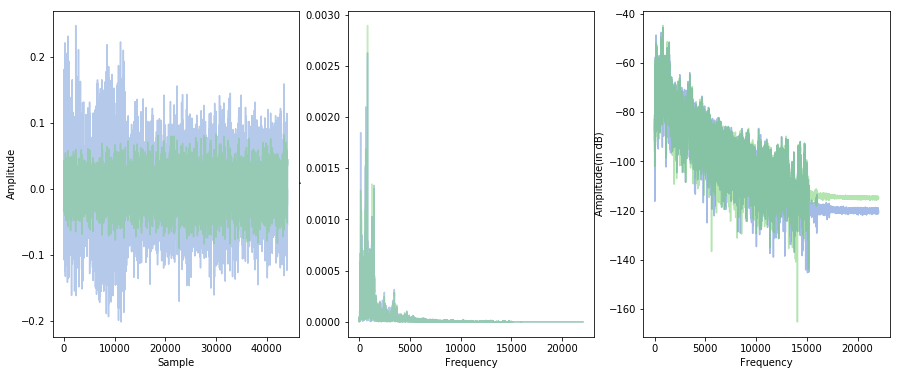

In [93]:
plotFrequencySpectrum(2)

# Dimentionality reduction: PCA

In [5]:
# a handy function for vizualizing principle components as a heatmap
# this allows you to see what dimensions in the 'original space' are
# active

def visualize_pca_comps_heatmap(plot, comps):
    heatmap = plot.pcolor(comps, cmap=plt.cm.Blues)
    
    x_lab = [i for i in range(comps.shape[1])]
    y_lab = [i for i in (range(comps.shape[0]))]
    
    plot.set_xticks(np.arange(comps.shape[1])+0.5, minor=False)
    plot.set_yticks(np.arange(comps.shape[0])+0.5, minor=False)
    
    # want a more natural, table-like display
    plot.invert_yaxis()
    
    plot.set_xticklabels(x_lab, minor=False)
    plot.set_yticklabels(y_lab, minor=False)
    
    plt.title('Heatmap of PCA components Rows: components, Cols: Original dimensions')

In [6]:
print (F_db.shape)
F2 = F.reshape(F_db.shape[0],-1)
print (F2.shape)

(2031, 2, 22050)
(2031, 44100)


Explained variance ratio: 
 [ 0.00067293  0.00067102  0.00066631  0.00065761  0.00065339  0.00064916
  0.00064689  0.00064298  0.00063744  0.00063567  0.00063384  0.00062823
  0.00062225  0.00062101  0.00061502  0.00060959  0.0006081   0.00060241
  0.00059921  0.00059407]
Explained variance ratio: 
 (170,)
Cumulative explained variance: 
 [ 0.76348063  0.76415165  0.76481796  0.76547556  0.76612895  0.76677811
  0.767425    0.76806798  0.76870543  0.7693411   0.76997494  0.77060317
  0.77122543  0.77184644  0.77246145  0.77307104  0.77367914  0.77428155
  0.77488076  0.77547483]
PCA components: 
 (170, 44100)
Wall time: 39.2 s


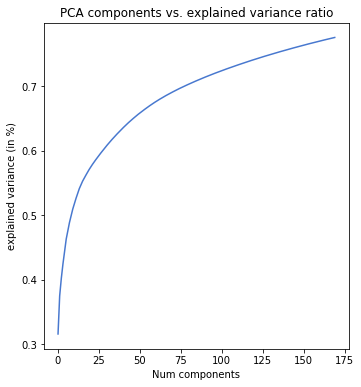

In [7]:
%%time
n_components = 170
pca_model = PCA(n_components)
pca_model.fit(F2)
joblib.dump(pca_model, 'model_pca.pkl') 
print('Explained variance ratio: \n', pca_model.explained_variance_ratio_[-20:])
print('Explained variance ratio: \n', pca_model.explained_variance_ratio_.shape)
print('Cumulative explained variance: \n', np.cumsum(pca_model.explained_variance_ratio_)[-20:])
print('PCA components: \n', pca_model.components_.shape)

plt.figure(figsize=(12, 6))
#p2 = plt.subplot(1, 2, 1)
#visualize_pca_comps_heatmap(p2, model.components_)
plt.subplot(1, 2, 2)
plt.plot(np.cumsum(pca_model.explained_variance_ratio_))
plt.xlabel('Num components')
plt.ylabel('explained variance (in %)')
plt.title('PCA components vs. explained variance ratio')

In [8]:
# Apply PCA Transformation to the input to create embeddings

In [9]:
%%time
print(F2.shape)
t= pca_model.transform(F2)
print(t.shape)

(2031, 44100)
(2031, 170)
Wall time: 2.66 s


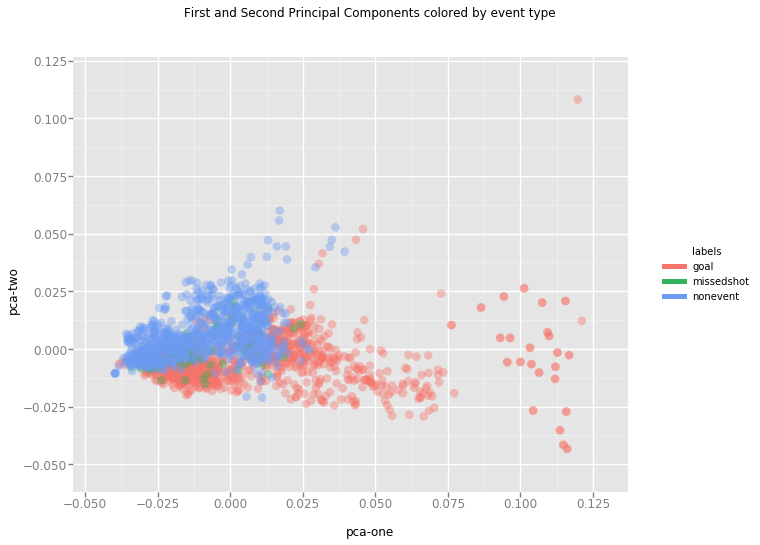

<ggplot: (-9223371872432090862)>

In [10]:
df_pca = pd.DataFrame(t[:,0], columns=["pca-one"])
df_pca["pca-two"] = t[:,1]
df_pca["labels"] = labels


chart = ggplot( df_pca, aes(x='pca-one', y='pca-two', color='labels') ) \
        + geom_point(size=75,alpha=0.4) \
        + ggtitle("First and Second Principal Components colored by event type")
chart

## Try tSNE
Use the reduced dimensions as were produced by PCA (to improve performance)

In [ ]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=160, n_iter=1200, learning_rate=25)
tsne_results = tsne.fit_transform(t)

In [ ]:
df_tsne = pd.DataFrame(tsne_results[:,0], columns=["x-tsne"])
df_tsne["y-tsne"] = tsne_results[:,1]
df_tsne["labels"] = labels

In [ ]:
chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='labels') ) \
        + geom_point(size=70,alpha=0.5) \
        + ggtitle("tSNE dimensions colored by event type")
chart

##  Try truncated SVD

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=n_components, n_iter=17, random_state=42)
svd_results = svd.fit_transform(F2)
print(svd.explained_variance_ratio_) 
print(svd.explained_variance_ratio_.sum()) 

In [ ]:
df_svd = pd.DataFrame(svd_results[:,0], columns=["svd-one"])
df_svd["svd-two"] = svd_results[:,1]
df_svd["labels"] = labels


chart = ggplot( df_svd, aes(x='svd-one', y='svd-two', color='labels') ) \
        + geom_point(size=75,alpha=0.6) \
        + ggtitle("First and Second SVD components colored by event type")
chart

# Classifiers

## Prepare training and test Data Sets

In [11]:
from sklearn.model_selection import train_test_split
index=np.array(np.arange(len(labels)))
data=pca_model.transform(F2)
data_train, data_test, labels_train, labels_test, index_train, index_test = train_test_split(data, labels, index, test_size=0.20, random_state=42)

## Utilities

In [12]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## KNN Classifier

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

model = KNeighborsClassifier(n_neighbors=3)
model.fit(data_train, labels_train)
joblib.dump(model, 'model_knn.pkl', protocol=2) 

test_predicted_labels = model.predict(data_test)

wrong_prediction = (test_predicted_labels != labels_test)

print('number of incorrect predictions: {0} out of {1}'.format(np.sum(wrong_prediction), len(labels_test)))

number of incorrect predictions: 48 out of 407


In [26]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print('accuracy: {0:.3g}%'.format(100*float(np.sum((test_predicted_labels == labels_test)))/len(labels_test)))
print("F1 score: {0:.3g}%".format(100*f1_score(labels_test, test_predicted_labels, average="weighted")))
print("Precision: {0:.3g}%".format(100*precision_score(labels_test, test_predicted_labels, average="weighted")))
print("Recall: : {0:.3g}%".format(100*recall_score(labels_test, test_predicted_labels, average="weighted")))   

accuracy: 88.2%
F1 score: 87.5%
Precision: 87.6%
Recall: : 88.2%


Confusion matrix, without normalization
[[196   2  22]
 [  5   4  10]
 [  6   3 159]]


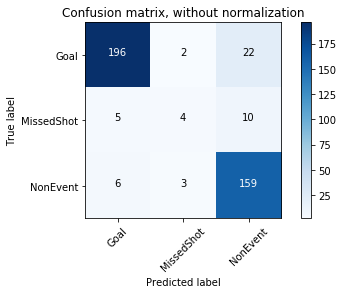

In [15]:
cnf_matrix = confusion_matrix(labels_test, test_predicted_labels)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Goal","MissedShot","NonEvent"],
                      title='Confusion matrix, without normalization')

In [16]:
event=[index
        for index,row in event_data.iterrows() 
        for i in np.arange(row["offset"],row["offset"]+row["timeToCapture"])]
second=[i-row["offset"]+1
        for index,row in event_data.iterrows() 
        for i in np.arange(row["offset"],row["offset"]+row["timeToCapture"])]
confused=index_test[(np.array(labels_test) == 'goal') & (np.array(test_predicted_labels) == 'nonevent')]
event=np.array(event)
second=np.array(second)

In [17]:
mixups=event_data.ix[event[confused]]
mixups["second"]=second[confused]
print("'secondOffset' is offset in the original clip")
print("'offset' is offset in the concatenated clip")
mixups

'secondOffset' is offset in the original clip
'offset' is offset in the concatenated clip


fileName  secondOffset  \
103                           bay_lei_1st_half_eng.mp4          2367   
80               watford_arsenal_1st_Half_10-14-17.mp4          2819   
58                                PSG_v_AND_2H_ENG.mp4          1987   
183                               JAP_V_BRA_2H_ENG.mp4          1062   
206                           spo_juv_2nd_half_eng.mp4          2031   
192                           lyo_eve_2nd_half_eng.mp4          2471   
24               watford_arsenal_1st_Half_10-14-17.mp4          2330   
21   SouthHampton-Manchester_United_2017-09-23_1st_...          1316   
58                                PSG_v_AND_2H_ENG.mp4          1987   
78               watford_arsenal_1st_Half_10-14-17.mp4          1533   
14                            AUG-BVB_1st_half_ENG.mp4          1522   
21   SouthHampton-Manchester_United_2017-09-23_1st_...          1316   
91                            lei_bay_2nd_half_eng.mp4          1704   
184                           JUV-BEN_1st_half_ENG.mp4          1295   
77               watford_arsenal_1st_Half_10-14-17.mp4          2329   
102                           bay_lei_1st_half_eng.mp4          1214   
72                             utd_cp_2nd_half_eng.mp4          2422   
58                                PSG_v_AND_2H_ENG.mp4          1987   
164                           bvb_bay_1st_half_eng.mp4          2268   
210                           tot_cry_2nd_half_eng.mp4           130   
58                                PSG_v_AND_2H_ENG.mp4          1987   
157                            BEL_V_MEX_1H_ESP_kk.mp4          1212   

    eventName  timeToCapture  offset  second  
103      goal              7    1378       7  
80       goal              9    1134       5  
58       goal              8     900       8  
183      goal              3    1826       2  
206      goal              9    1937       6  
192      goal              2    1876       2  
24       goal             10     342       3  
21       goal             15     207       6  
58       goal              8     900       6  
78       goal              5    1121       5  
14       goal              5      97       4  
21       goal             15     207      14  
91       goal              7    1246       6  
184      goal             10    1829       6  
77       goal              8    1113       5  
102      goal             10    1368       9  
72       goal              1    1090       1  
58       goal              8     900       4  
164      goal              5    1739       1  
210      goal              8    1964       5  
58       goal              8     900       7  
157      goal             10    1688       3

# Gradient Boosting Classifier

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
gra = GradientBoostingClassifier()
gra.fit(data_train, labels_train)
joblib.dump(model, 'model_gra.pkl', protocol=2) 
print('Accuracy (GBC):', gra.score(data_test, labels_test))

Accuracy (GBC): 0.874692874693


In [19]:
test_predicted_labels_gra = gra.predict(data_test)
wrong_prediction_gra = (test_predicted_labels_gra != labels_test)
print('number of incorrect predictions: {0} out of {1}'.format(np.sum(wrong_prediction), len(labels_test)))


number of incorrect predictions: 48 out of 407


In [20]:
print('accuracy: {0:.3g}%'.format(100*float(np.sum((test_predicted_labels_gra == labels_test)))/len(labels_test)))
print("F1 score: {0:.3g}%".format(100*f1_score(labels_test, test_predicted_labels_gra, average="weighted")))
print("Precision: {0:.3g}%".format(100*precision_score(labels_test, test_predicted_labels_gra, average="weighted")))
print("Recall: : {0:.3g}%".format(100*recall_score(labels_test, test_predicted_labels_gra, average="weighted")))   

accuracy: 87.5%
F1 score: 85.8%
Precision: 86%
Recall: : 87.5%


# SVM Classifier

In [110]:
from sklearn import svm
from sklearn import datasets

model_svm = svm.SVC()
model_svm.fit(data_train, labels_train)
joblib.dump(model_svm, 'model_svm.pkl', protocol=2) 
test_predicted_labels = model_svm.predict(data_test)
wrong_prediction = (test_predicted_labels != labels_test)
print('number of incorrect predictions: {0} out of {1}'.format(np.sum(wrong_prediction), len(labels_test)))

number of incorrect predictions: 159 out of 341


In [111]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print('accuracy: {0:.3g}%'.format(100*float(np.sum((test_predicted_labels == labels_test)))/len(labels_test)))
print("F1 score: {0:.3g}%".format(100*f1_score(labels_test, test_predicted_labels, average="weighted")))
print("Precision: {0:.3g}%".format(100*precision_score(labels_test, test_predicted_labels, average="weighted")))
print("Recall: : {0:.3g}%".format(100*recall_score(labels_test, test_predicted_labels, average="weighted")))

accuracy: 53.4%
F1 score: 37.1%
Precision: 28.5%
Recall: : 53.4%
